 토트넘 우승 확률 예측



클래스 가중치: {np.int64(0): np.float64(0.5265306122448979), np.int64(1): np.float64(9.923076923076923)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7083 - loss: 0.7056 - precision: 0.0293 - recall: 0.2471
Epoch 1: val_loss improved from inf to 0.51084, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7105 - loss: 0.7070 - precision: 0.0294 - recall: 0.2432 - val_accuracy: 0.8385 - val_loss: 0.5108 - val_precision: 0.2000 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 2/200
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7907 - loss: 0.5150 - precision: 0.0931 - recall: 0.4545
Epoch 2: val_loss improved from 0.51084 to 0.42224, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7910 - loss: 0.5146 - precision: 0.1003 - recall: 0.4857 - val_accuracy: 0.7538 - val_loss: 0.4222 - val_precision: 0.1579 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/200
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7230 - loss: 0.4006 - precision: 0.1305 - recall: 1.0000
Epoch 3: val_loss improved from 0.42224 to 0.37947, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7255 - loss: 0.3984 - precision: 0.1336 - recall: 1.0000 - val_accuracy: 0.7615 - val_loss: 0.3795 - val_precision: 0.1622 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/200
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7013 - loss: 0.3958 - precision: 0.0948 - recall: 0.7310
Epoch 4: val_loss improved from 0.37947 to 0.37149, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7075 - loss: 0.3820 - precision: 0.1073 - recall: 0.7843 - val_accuracy: 0.7692 - val_loss: 0.3715 - val_precision: 0.1667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/200
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7140 - loss: 0.3353 - precision: 0.1288 - recall: 1.0000
Epoch 5: val_loss improved from 0.37149 to 0.36859, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7163 - loss: 0.3338 - precision: 0.1312 - recall: 1.0000 - val_accuracy: 0.7846 - val_loss: 0.3686 - val_precision: 0.1765 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/200
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7650 - loss: 0.2806 - precision: 0.1510 - recall: 1.0000
Epoch 6: val_loss improved from 0.36859 to 0.36062, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7671 - loss: 0.2789 - precision: 0.1543 - recall: 1.0000 - val_accuracy: 0.7923 - val_loss: 0.3606 - val_precision: 0.1818 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7692 - loss: 0.3102 - precision: 0.1556 - recall: 1.0000
Epoch 7: val_loss improved from 0.36062 to 0.33730, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7700 - loss: 0.3091 - precision: 0.1568 - recall: 1.0000 - val_accuracy: 0.8077 - val_loss: 0.3373 - val_precision: 0.1935 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.2614 - precision: 0.1593 - recall: 1.0000
Epoch 8: val_loss improved from 0.33730 to 0.32823, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7764 - loss: 0.2610 - precision: 0.1606 - recall: 1.0000 - val_accuracy: 0.8385 - val_loss: 0.3282 - val_precision: 0.2222 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/200
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8090 - loss: 0.2374 - precision: 0.1785 - recall: 1.0000
Epoch 9: val_loss improved from 0.32823 to 0.29880, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8124 - loss: 0.2369 - precision: 0.1854 - recall: 1.0000 - val_accuracy: 0.8385 - val_loss: 0.2988 - val_precision: 0.2222 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.4732 - precision: 0.1141 - recall: 0.6374         
Epoch 10: val_loss did not improve from 0.29880
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8168 - loss: 0.3850 - precision: 0.1685 - recall: 0.7843 - val_accuracy: 0.8462 - val_loss: 0.3161 - val_precision: 0.2308 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8290 - loss: 0.2301 - precision: 0.1937 - recall: 0.9719
Epoch 11: val_loss improved from 0.29880 to 0.28437, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8296 - loss: 0.2300 - precision: 0.1952 - recall: 0.9716 - val_accuracy: 0.8692 - val_loss: 0.2844 - val_precision: 0.2609 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/200
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.2175 - precision: 0.2177 - recall: 0.9772
Epoch 12: val_loss improved from 0.28437 to 0.28268, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8561 - loss: 0.2174 - precision: 0.2202 - recall: 0.9763 - val_accuracy: 0.8692 - val_loss: 0.2827 - val_precision: 0.2609 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 13/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8521 - loss: 0.2305 - precision: 0.2204 - recall: 1.0000
Epoch 13: val_loss did not improve from 0.28268
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8524 - loss: 0.2301 - precision: 0.2219 - recall: 1.0000 - val_accuracy: 0.8692 - val_loss: 0.2855 - val_precision: 0.2609 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 14/200
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8421 - loss: 0.2167 - precision: 0.2135 - recall: 1.0000
Epoch 14: val_loss improved from 0.28268 to 0.24586, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8443 - loss: 0.2146 - precision: 0.2183 - recall: 1.0000 - val_accuracy: 0.8769 - val_loss: 0.2459 - val_precision: 0.2727 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/200
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.2729 - precision: 0.1871 - recall: 0.7609
Epoch 15: val_loss did not improve from 0.24586
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8493 - loss: 0.2655 - precision: 0.1972 - recall: 0.7843 - val_accuracy: 0.8846 - val_loss: 0.2564 - val_precision: 0.2857 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 16/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8764 - loss: 0.2058 - precision: 0.2536 - recall: 1.0000
Epoch 16: val_loss did not improve from 0.24586
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8769 - loss: 0.2052 - precision: 0.2555 - recall: 1.0000 - val_accuracy: 0.8846 - val_loss: 0.2560 - val_precision: 0.2857 - val_recall: 1.0000 - learning_rate: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8742 - loss: 0.1923 - precision: 0.2483 - recall: 1.0000 - val_accuracy: 0.8923 - val_loss: 0.2430 - val_precision: 0.3000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 18/200
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.1653 - precision: 0.2525 - recall: 1.0000
Epoch 18: val_loss improved from 0.24298 to 0.22719, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8812 - loss: 0.1644 - precision: 0.2595 - recall: 1.0000 - val_accuracy: 0.9000 - val_loss: 0.2272 - val_precision: 0.3158 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 19/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8954 - loss: 0.1664 - precision: 0.2828 - recall: 0.9963
Epoch 19: val_loss improved from 0.22719 to 0.20568, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8955 - loss: 0.1664 - precision: 0.2842 - recall: 0.9953 - val_accuracy: 0.9154 - val_loss: 0.2057 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 20/200
24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8983 - loss: 0.1706 - precision: 0.2770 - recall: 1.0000
Epoch 20: val_loss did not improve from 0.20568
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9002 - loss: 0.1722 - precision: 0.2952 - recall: 1.0000 - val_accuracy: 0.9000 - val_loss: 0.2378 - val_precision: 0.3158 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 21/200
24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8840 - loss: 0.1921 - precision: 0.2515 - recall: 1.0000
Epoch 21: val_loss did not improve from 0.20568
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8884 - loss: 0.1832 - precision: 0.2736 - recall: 1.0000 - val_accuracy: 0.9077 - val_loss: 0.2131 - val_precision: 0.3333 - val_recall: 1.0000 - learning_rate:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9119 - loss: 0.1443 - precision: 0.3212 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.2004 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 27/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9084 - loss: 0.1624 - precision: 0.2803 - recall: 1.0000 
Epoch 27: val_loss improved from 0.20037 to 0.19395, saving model to best_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9171 - loss: 0.1530 - precision: 0.3361 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.1939 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 28/200
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9158 - loss: 0.1455 - precision: 0.3304 - recall: 1.0000
Epoch 28: val_loss did not improve from 0.19395
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9166 - loss: 0.1451 - precision: 0.3362 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.2088 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 29/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.1785 - precision: 0.2803 - recall: 1.0000 
Epoch 29: val_loss did not improve from 0.19395
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9145 - loss: 0.1712 - precision: 0.3270 - recall: 0.9953 - val_accuracy: 0.9154 - val_loss: 0.2136 - val_precision: 0.3529 - val_recall: 1.0000 - learning

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9295 - loss: 0.1363 - precision: 0.3696 - recall: 0.9953 - val_accuracy: 0.9154 - val_loss: 0.1898 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 33/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.1565 - precision: 0.3164 - recall: 1.0000  
Epoch 33: val_loss did not improve from 0.18983
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9259 - loss: 0.1507 - precision: 0.3587 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.2074 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 34/200
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9034 - loss: 0.2067 - precision: 0.2630 - recall: 0.7609
Epoch 34: val_loss did not improve from 0.18983
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9051 - loss: 0.1999 - precision: 0.2755 - recall: 0.7843 - val_accuracy: 0.9154 - val_loss: 0.1946 - val_precision: 0.3529 - val_recall: 1.0000 - learni

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9192 - loss: 0.1370 - precision: 0.3422 - recall: 1.0000 - val_accuracy: 0.9308 - val_loss: 0.1759 - val_precision: 0.4000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 37/200
17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9178 - loss: 0.1421 - precision: 0.2991 - recall: 1.0000 
Epoch 37: val_loss did not improve from 0.17591
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9227 - loss: 0.1406 - precision: 0.3499 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.1831 - val_precision: 0.3529 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 38/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9238 - loss: 0.1442 - precision: 0.3569 - recall: 1.0000
Epoch 38: val_loss did not improve from 0.17591
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9242 - loss: 0.1437 - precision: 0.3593 - recall: 1.0000 - val_accuracy: 0.9154 - val_loss: 0.1882 - val_precision: 0.3529 - val_recall: 1.0000 - learning

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9284 - loss: 0.1322 - precision: 0.3659 - recall: 1.0000 - val_accuracy: 0.9385 - val_loss: 0.1747 - val_precision: 0.4286 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 46/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9266 - loss: 0.1342 - precision: 0.3274 - recall: 1.0000 
Epoch 46: val_loss did not improve from 0.17466
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9305 - loss: 0.1307 - precision: 0.3747 - recall: 1.0000 - val_accuracy: 0.9385 - val_loss: 0.1757 - val_precision: 0.4286 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 47/200
18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9135 - loss: 0.1236 - precision: 0.2925 - recall: 1.0000 
Epoch 47: val_loss did not improve from 0.17466
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9223 - loss: 0.1278 - precision: 0.3511 - recall: 1.0000 - val_accuracy: 0.9231 - val_loss: 0.1823 - val_precision: 0.3750 - val_recall: 1.0000 - learnin

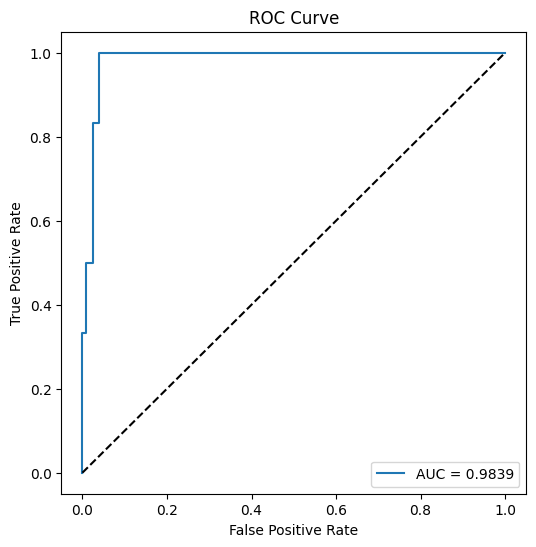

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step

2024-25 시즌 토트넘 우승 확률 예측: 0.00%


In [6]:
# -----------------------------------
# 1) 라이브러리 & 랜덤 시드 설정
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.metrics import Precision, Recall

from google.colab import drive
drive.mount('/content/drive')

# 랜덤 시드 고정
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# -----------------------------------
# 2) 데이터 로드 & 전처리
df = pd.read_csv('/content/drive/MyDrive/dl/England CSV.csv')
df = df.rename(columns={
    'FTH Goals': 'FTHG', 'FTA Goals': 'FTAG',
    'HTH Goals': 'HTHG', 'HTA Goals': 'HTAG',
    'FT Result': 'FTR', 'HT Result': 'HTR'
})
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Season'] = df['Season'].str.replace('/', '-')

# 시즌·팀별 집계
def get_result(row, team):
    if row['HomeTeam'] == team:
        return 1 if row['FTR']=='H' else (0.5 if row['FTR']=='D' else 0)
    else:
        return 1 if row['FTR']=='A' else (0.5 if row['FTR']=='D' else 0)

teams = pd.unique(df[['HomeTeam','AwayTeam']].values.ravel())
seasons = df['Season'].unique()
agg_rows = []

for season in seasons:
    dft = df[df['Season']==season]
    for team in teams:
        sub = dft[(dft['HomeTeam']==team)|(dft['AwayTeam']==team)]
        if sub.empty: continue

        wins = sum(sub.apply(lambda r: get_result(r, team)==1, axis=1))
        draws = sum(sub.apply(lambda r: get_result(r, team)==0.5, axis=1))
        losses = sum(sub.apply(lambda r: get_result(r, team)==0, axis=1))
        gf = sum(np.where(sub['HomeTeam']==team, sub['FTHG'], sub['FTAG']))
        ga = sum(np.where(sub['HomeTeam']==team, sub['FTAG'], sub['FTHG']))
        pts = wins*3 + draws*1

        agg_rows.append({
            'Season': season,
            'Team': team,
            'Wins': wins,
            'Draws': draws,
            'Losses': losses,
            'GF': gf,
            'GA': ga,
            'GD': gf - ga,
            'Points': pts,
            'Matches': len(sub)
        })

df_team = pd.DataFrame(agg_rows)

# 챔피언 레이블 부착
champions = (
    df_team.loc[df_team.groupby('Season')['Points'].idxmax(), ['Season','Team']]
    .rename(columns={'Team':'Champion'})
)
df_team = df_team.merge(champions, on='Season')
df_team['IsChampion'] = (df_team['Team'] == df_team['Champion']).astype(int)

# 특성/레이블 분리
features = ['Wins','Draws','Losses','GF','GA','GD','Points','Matches']
X = df_team[features].values
y = df_team['IsChampion'].values

# train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# 클래스 가중치 계산
unique_classes = np.unique(y_train)
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weight_dict = dict(zip(unique_classes, class_weights_vals))
print("클래스 가중치:", class_weight_dict)

# -----------------------------------
# 3) 모델 구축
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()

# -----------------------------------
# 4) 콜백 설정
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint(
    'best_model.h5', monitor='val_loss',
    save_best_only=True, mode='min', verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

# -----------------------------------
# 5) 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[es, checkpoint_cb, reduce_lr, tb_cb],
    verbose=1
)

# -----------------------------------
# 6) 성능 평가
loss, acc, prec, rec = model.evaluate(X_val, y_val, verbose=0)
print(f"\n검증 결과 -> Loss: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

# 7) Confusion Matrix & ROC-AUC
y_val_pred_prob = model.predict(X_val).ravel()
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC-AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 8) 토트넘 2024-25 시즌 우승 확률 예측
tott_2425 = df_team[
    (df_team['Season']=='2024-25') & (df_team['Team']=='Tottenham')
][features].values
tott_scaled = scaler.transform(tott_2425)
prob = model.predict(tott_scaled)[0][0]
print(f"\n2024-25 시즌 토트넘 우승 확률 예측: {prob*100:.2f}%")


 컬럼 구성 예시 (주요 컬럼만 발췌)  
  - `Date`       : 경기 날짜 (day-first 포맷)  
  - `HomeTeam`   : 홈(주최) 팀 이름  
  - `AwayTeam`   : 어웨이(원정) 팀 이름  
  - `FTH Goals`  : 풀타임(Home 팀 득점) → 코드 내에서 `FTHG`  
  - `FTA Goals`  : 풀타임(Away 팀 득점) → 코드 내에서 `FTAG`  
  - `FT Result`  : 풀타임 결과 (홈 승 ‘H’, 무승부 ‘D’, 어웨이 승 ‘A’) → 코드 내에서 `FTR`  
  - `HTH Goals`  : 하프타임(Home 팀 득점) → 코드 내에서 `HTHG`  
  - `HTA Goals`  : 하프타임(Away 팀 득점) → 코드 내에서 `HTAG`  
  - `HT Result`  : 하프타임 결과 (홈 승 ‘H’, 무승부 ‘D’, 어웨이 승 ‘A’) → 코드 내에서 `HTR`  
  - `Season`     : 시즌 정보 (예: `2023/24` → `2023-24` 으로 변환)  
  - 각 시즌별로, **팀마다** 해당 시즌에 치른 모든 경기 결과를 모아 아래 항목 계산  
  - Wins    : 승리 횟수  
  - Draws   : 무승부 횟수  
  - Losses  : 패배 횟수  
  - GF (Goals For) : 총 득점  
  - GA (Goals Against) : 총 실점  
  - GD (Goal Difference) : GF − GA  
  - Points  : 승점(승리 3점, 무승부 1점)  
  - Matches : 총 경기 수  
  - **우승팀 레이블링**  
     - `Season`별로 `Points` 최댓값을 가진 `Team`을 뽑아 `Champion` 컬럼 생성  
     - 그 후, 팀별 통계표에 `IsChampion` = 1(우승), 0(비우승) Boolean 형태로 부착  

